In [ ]:
#default_exp augment.signal

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from fastcore.transform import Transform
from fastai2.data.all import *
from fastai2_audio.core.all import *
from fastai2.vision.augment import RandTransform

In [ ]:
from setup_example import *

In [ ]:
# export
import colorednoise as cn

In [ ]:
#export
_all_ = ["AudioPadType", "NoiseColor"]

# Signal Transforms
> Transforms that operate on audio signals

## Signal Cropping/Padding

<div class = "alert alert-block alert-info"> CropSignal and CropTime can either be merged into one function, or they can outsource the bulk of their behavior to a shared cropping function</div>

In [ ]:
#export
mk_class('AudioPadType', **{o:o.lower() for o in ['Zeros', 'Zeros_After', 'Repeat']},
         doc="All methods of padding audio as attributes to get tab-completion and typo-proofing")

In [ ]:
#export
class CropSignal(Transform):
    '''Crops signal to be length specified in ms by duration, padding if needed'''
    def __init__(self, duration, pad_mode=AudioPadType.Zeros):
        store_attr(self, "duration, pad_mode")
        
    def encodes(self, ai: AudioTensor)->AudioTensor:
        sig = ai.data
        orig_samples = ai.nsamples
        crop_samples = int((self.duration/1000)*ai.sr)
        if orig_samples == crop_samples: return ai
        elif orig_samples < crop_samples: 
            ai.data = _tfm_pad_signal(sig, crop_samples, pad_mode=self.pad_mode)
        else:
            crop_start = random.randint(0, int(orig_samples-crop_samples))
            ai.data = sig[:,crop_start:crop_start+crop_samples]
        return ai


In [ ]:
#export
def _tfm_pad_signal(sig, width, pad_mode=AudioPadType.Zeros):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,x = sig.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros_after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c, zeros_front))
        pad_back = torch.zeros((c, width-x-zeros_front))
        return torch.cat((pad_front, sig, pad_back), 1)
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sig.repeat(1,repeats)[:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros_after', or 'repeat'")

In [ ]:
inp, out1000 = show_transform(CropSignal(1000), GenExample.audio_sc, show=None)
inp, out2000 = show_transform(CropSignal(2000), GenExample.audio_sc, show=None)
inp, out5000 = show_transform(CropSignal(5000), GenExample.audio_sc, show=None)

Original Audio is 3.64 seconds


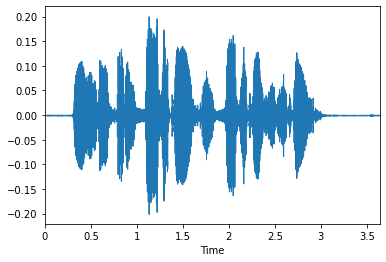

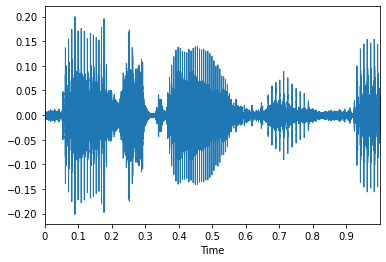

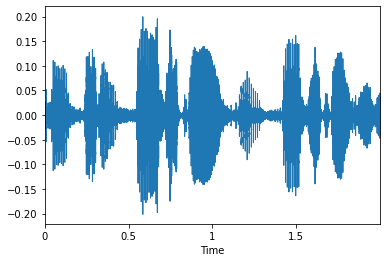

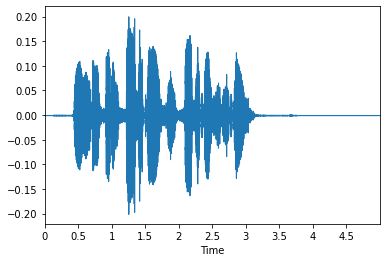

In [ ]:
print(f"Original Audio is {inp.duration:.2f} seconds")
inp.show(hear=False)
out1000.show(hear=False)
out2000.show(hear=False)
out5000.show(hear=False)

In [ ]:
test_eq(out1000.nsamples, 1*inp.sr)
test_eq(out2000.nsamples, 2*inp.sr)
test_eq(out5000.nsamples, 5*inp.sr)
test_eq(out1000.duration, 1)
test_eq(out2000.duration, 2)
test_eq(out5000.duration, 5)

In [ ]:
inp, mc1000 = show_transform(CropSignal(1000), GenExample.audio_mc, show=None)
inp, mc2000 = show_transform(CropSignal(2000), GenExample.audio_mc, show=None)
inp, mc5000 = show_transform(CropSignal(5000), GenExample.audio_mc, show=None)
test_eq(mc1000.duration, 1)
test_eq(mc2000.duration, 2)
test_eq(mc5000.duration, 5)

### Test Signal Padding Modes

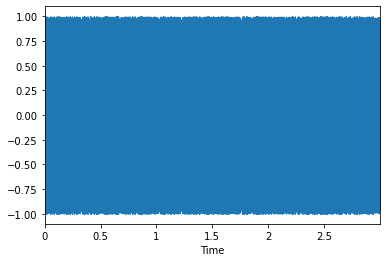

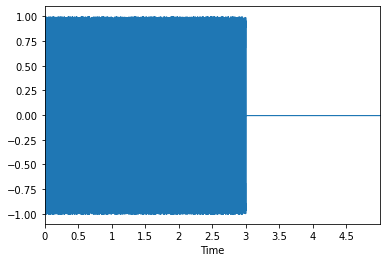

In [ ]:
# test pad_mode zeros-after
audio_orig = GenExample.audio_sc()
cropsig_pad_after = CropSignal(5000, pad_mode=AudioPadType.Zeros_After)
# generate a random input signal that is 3s long
gen_func = lambda: AudioTensor(torch.rand(1, 48000), 16000)
inp, out = show_transform(cropsig_pad_after, gen_func)
# test end of signal is padded with zeros
test_eq(out[:,-10:], torch.zeros_like(out)[:,-10:])
# test front of signal is not padded with zeros
test_ne(out[:,0:10] , out[:,-10:])

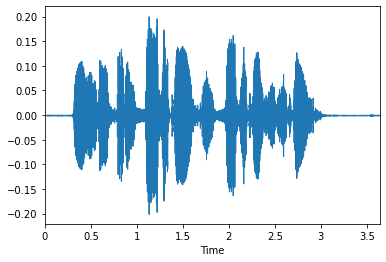

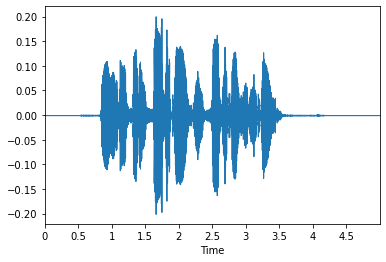

In [ ]:
# test pad_mode zeros by verifying signal begins and ends with zeros
cropsig_pad = CropSignal(5000)
inp, out = show_transform(cropsig_pad, GenExample.audio_sc)
test_eq(out[:,0:2], out[:,-2:])

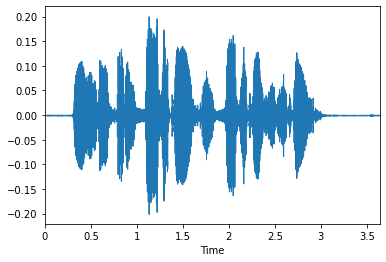

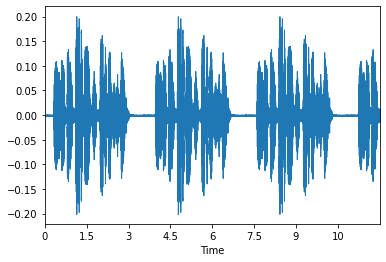

In [ ]:
# test pad_mode repeat by making sure that columns are equal at the appropriate offsets
cropsig_repeat = CropSignal(12000, pad_mode=AudioPadType.Repeat)
inp, out = show_transform(cropsig_repeat, GenExample.audio_sc)
for i in range(inp.nsamples):
    test_eq(out[:,i], out[:,i+inp.nsamples])
    test_eq(out[:,i], out[:,i+2*inp.nsamples])

In [ ]:
# test bad pad_mode doesnt fail silently
test_fail(CropSignal(12000, pad_mode="tenchify"))

In [ ]:
# demonstrate repeat mode works on multichannel data (change "show=None" to "True" to see output)
inp, out = show_transform(cropsig_repeat, GenExample.audio_mc, show=False)

#### Cropping/Padding Timing Tests

In [ ]:
%%time
aud1s = CropSignal(1000)(audio_orig)

CPU times: user 143 µs, sys: 7 µs, total: 150 µs
Wall time: 153 µs


In [ ]:
%%time
aud2s = CropSignal(2000)(audio_orig)

CPU times: user 431 µs, sys: 0 ns, total: 431 µs
Wall time: 319 µs


In [ ]:
%%time
aud5s = CropSignal(5000)(audio_orig)

CPU times: user 471 µs, sys: 27 µs, total: 498 µs
Wall time: 341 µs


## Signal Shifting

In [ ]:
#v1 used scipy.ndimage.interpolation.shift but it was extremely slow (14-16ms) so I rewrote and got it down to 50µs

In [ ]:
np.roll(np.array([1,2,3,4,5,6,7]), 2)

array([6, 7, 1, 2, 3, 4, 5])

In [ ]:
# version before optimization
# def _shift(sig, s):
#     samples = sig.shape[-1]
#     if   s == 0: return sig
#     elif  s < 0: return torch.cat([sig[...,-1*s:], torch.zeros_like(sig)[...,s:]], dim=-1)
#     else       : return torch.cat([torch.zeros_like(sig)[...,:s], sig[...,:samples-s]], dim=-1)

# def shift_signal(t:torch.Tensor, shift, roll):
#     #refactor 2nd half of this statement to just take and roll the final axis
#     if roll: t.data = torch.from_numpy(np.roll(t.numpy(), shift, axis=-1))
#     else   : t.data = _shift(t, shift)
#     return t

In [ ]:
#export
def _shift(sig, s):
    if s == 0: return sig
    out = torch.zeros_like(sig)
    if  s < 0: out[...,:s] = sig[...,-s:]
    else: out[...,s:] = sig[...,:-s]
    return out

def shift_signal(t:torch.Tensor, shift, roll):
    #refactor 2nd half of this statement to just take and roll the final axis
    if roll: t.data = torch.from_numpy(np.roll(t.numpy(), shift, axis=-1))
    else   : t.data = _shift(t, shift)
    return t

In [ ]:
# export
class SignalShifter(RandTransform):
    def __init__(self, p=0.5, max_pct= 0.2, max_time=None, direction=0, roll=False):
        if direction not in [-1, 0, 1]: raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
        store_attr(self, "max_pct,max_time,direction,roll")
        super().__init__(p=p)

    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.shift_factor = random.uniform(-1, 1)
        if self.direction != 0: self.shift_factor = self.direction*abs(self.shift_factor)
        
    def encodes(self, ai:AudioTensor):        
        if self.max_time is None: s = self.shift_factor*self.max_pct*ai.nsamples
        else:                     s = self.shift_factor*self.max_time*ai.sr
        ai.data = shift_signal(ai.data, int(s), self.roll)
        return ai
    
    def encodes(self, sg:AudioSpectrogram):
        if self.max_time is None: s = self.shift_factor*self.max_pct*sg.width
        else:                     s = self.shift_factor*self.max_time*sg.sr
        return shift_signal(sg, int(s), self.roll)

In [ ]:
t1 = torch.tensor([[1,2,3,4,5,6,7,8,9,10]])
t3 = torch.tensor([[1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15,16,17,18,19,20],[21,22,23,24,25,26,27,28,29,30]])
b4 = torch.stack([t3,t3,t3,t3])
test_eq(b4.shape, torch.Size([4, 3, 10]))
test_eq(_shift(t1,4), tensor([[0, 0, 0, 0, 1, 2, 3, 4, 5, 6]]))
test_eq(_shift(t3,-2), tensor([[3,4,5,6,7,8,9,10,0,0],[13,14,15,16,17,18,19,20,0,0],[23,24,25,26,27,28,29,30,0,0]]))

In [ ]:
shift_signal(b4, 4, roll=False)

tensor([[[ 0,  0,  0,  0,  1,  2,  3,  4,  5,  6],
         [ 0,  0,  0,  0, 11, 12, 13, 14, 15, 16],
         [ 0,  0,  0,  0, 21, 22, 23, 24, 25, 26]],

        [[ 0,  0,  0,  0,  1,  2,  3,  4,  5,  6],
         [ 0,  0,  0,  0, 11, 12, 13, 14, 15, 16],
         [ 0,  0,  0,  0, 21, 22, 23, 24, 25, 26]],

        [[ 0,  0,  0,  0,  1,  2,  3,  4,  5,  6],
         [ 0,  0,  0,  0, 11, 12, 13, 14, 15, 16],
         [ 0,  0,  0,  0, 21, 22, 23, 24, 25, 26]],

        [[ 0,  0,  0,  0,  1,  2,  3,  4,  5,  6],
         [ 0,  0,  0,  0, 11, 12, 13, 14, 15, 16],
         [ 0,  0,  0,  0, 21, 22, 23, 24, 25, 26]]])

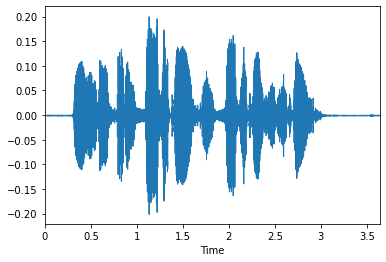

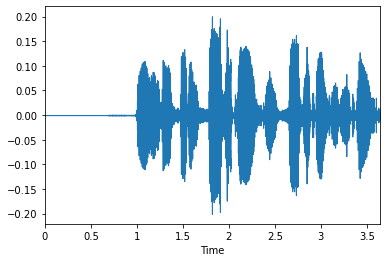

In [ ]:
shifter = SignalShifter(p=1, max_pct=0.5)
inp, out = show_transform(shifter, GenExample.audio_sc)

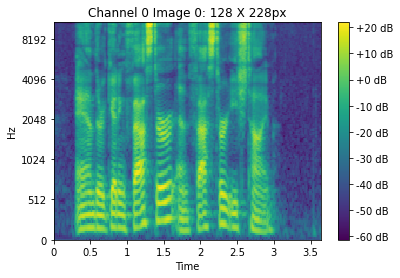

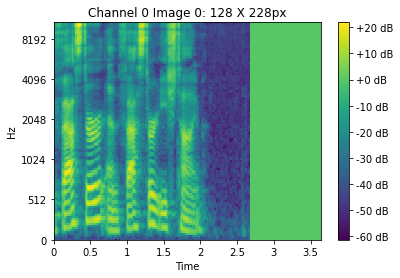

In [ ]:
inp, out = show_transform(shifter, GenExample.sg_sc)

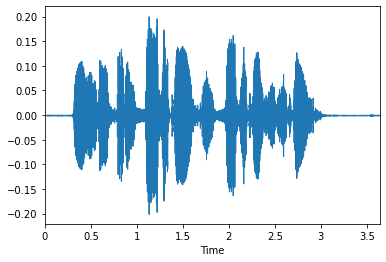

torch.Size([8, 1, 58240])


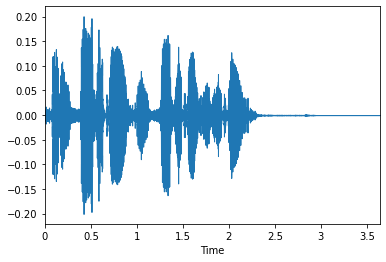

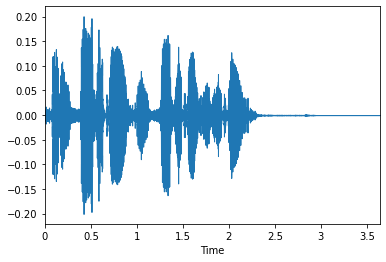

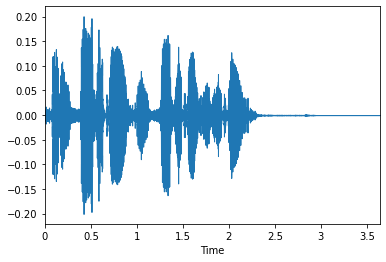

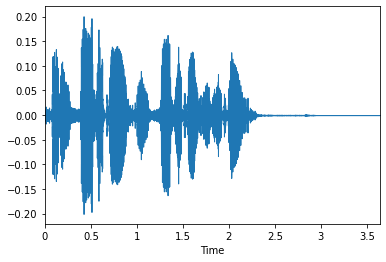

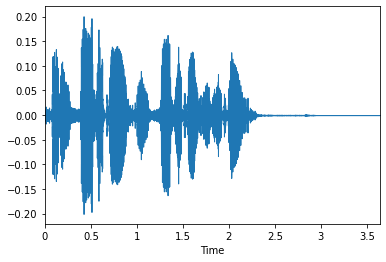

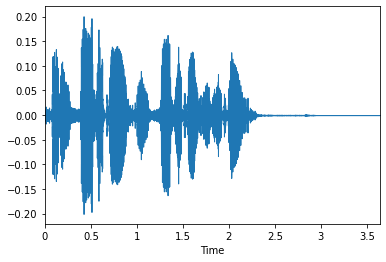

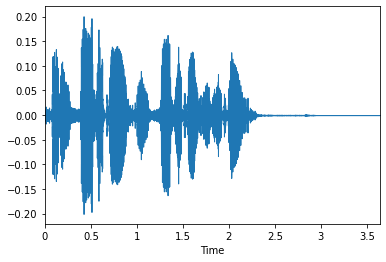

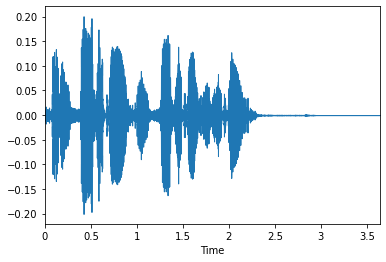

In [ ]:
audio_orig = GenExample.audio_sc_batch(8)
shifter = SignalShifter(p=1, max_pct=1)
AudioTensor(audio_orig[0], 16000).show(hear=False)
altered = shifter(audio_orig, split_idx=0)

#AudioTensor((audio_orig[0], 16000, None)).show()
print(altered.shape)
for sig in altered:
    AudioTensor(sig, 16000).show(hear=False)


In [ ]:
audio_orig = GenExample.audio_sc()
sg_orig = GenExample.sg_sc()

In [ ]:
%%time
altered = shifter(audio_orig, split_idx=0)

CPU times: user 345 µs, sys: 16 µs, total: 361 µs
Wall time: 247 µs


In [ ]:
%%timeit -n3
altered = shifter(audio_orig, split_idx=0)

76.4 µs ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [ ]:
audio_orig = GenExample.audio_sc_batch(32)

In [ ]:
%%time
altered = shifter(audio_orig, split_idx=0)

CPU times: user 3.8 ms, sys: 178 µs, total: 3.97 ms
Wall time: 693 µs


In [ ]:
%%time
altered = shifter(sg_orig, split_idx=0)

CPU times: user 353 µs, sys: 16 µs, total: 369 µs
Wall time: 232 µs


### Example without rolling

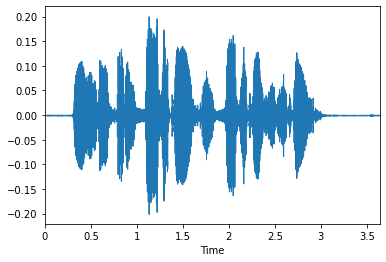

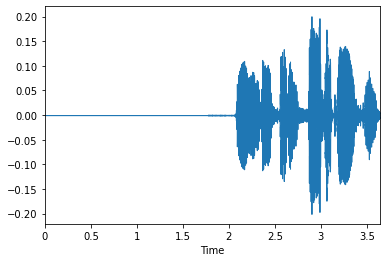

In [ ]:
shifter = SignalShifter(p=1, max_pct=0.5)
inp, out = show_transform(shifter, GenExample.audio_sc)

In [ ]:
# test a time shift of 1s never shifts more than 1s
for i in range(100):
    time_shifter = SignalShifter(p=1, max_time=1)
    gen_func = lambda: AudioTensor(torch.ones(1, 16000), 16000)
    inp, out = show_transform(time_shifter, gen_func, show=None)
    #just_ones = AudioTensor((torch.ones(16000).unsqueeze(0), 16000, None))
    test_eq(False, torch.allclose(out, torch.zeros(16000)))

In [ ]:
# demonstrate shifting works on multichannel data (alter show to True to see)
shifter = SignalShifter(p=1, max_time=1)
inp, out = show_transform(shifter, GenExample.audio_mc, show=False)

### Example with rolling

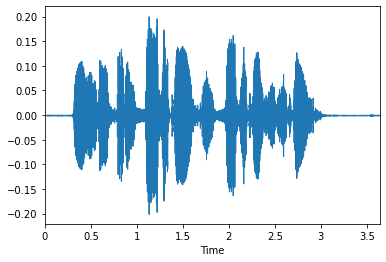

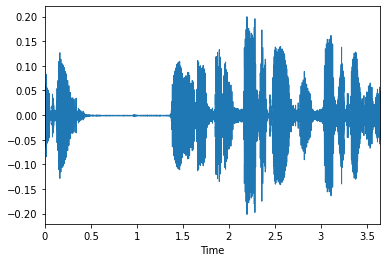

In [ ]:
shift_and_roll = SignalShifter(p=1, max_pct=0.5, roll=True)
inp, out = show_transform(shift_and_roll, GenExample.audio_sc)
test_eq(inp.data.shape, out.data.shape)

#### Shift Timing Tests

In [ ]:
audio_orig = GenExample.audio_sc()

In [ ]:
%%time
shifted = shifter(audio_orig, split_idx=0)

CPU times: user 341 µs, sys: 15 µs, total: 356 µs
Wall time: 254 µs


In [ ]:
%%time
shifted = shift_and_roll(audio_orig, split_idx=0)

CPU times: user 258 µs, sys: 11 µs, total: 269 µs
Wall time: 244 µs


## Add Noise to Signal

Adds noise proportional to the energy of the signal (mean of abs value), and the specified noise level.

This uses [colorednoise](https://github.com/felixpatzelt/colorednoise)(imported as 'cn'), developed by a data scientist named [Felix Patzelt](https://github.com/felixpatzelt). It allows you to use one simple function to create white, brown, pink and other [colors of noise](https://en.wikipedia.org/wiki/Colors_of_noise). Each color corresponds to an exponent, violet is -2, blue -1, white is 0, pink is 1, and brown is 2. We abstract this with a class that enumerates the list and shifts it down by two so the exponents are correct, and so that we get tab-completion.

Because this actually draws a spectrogram and does an istft on it, it is about 10x faster if we implement our own white noise (simple and worth doing since it's the most common noise we'll want to use, this is what the `if color=0` line does, it overrides and generates white noise using our own simple algo. (**Note: Most recent timing tests actually show the opposite, that generating our own white noise is 3x slower? This should be looked into later**) 

For just plain white noise, if we revert to remove the dependency on this library, the noise can be created with  
`noise = torch.randn_like(ai.sig) * ai.sig.abs().mean() * noise_level`

In [ ]:
# export
mk_class('NoiseColor', **{o:i-2 for i,o in enumerate(['Violet', 'Blue', 'White', 'Pink', 'Brown'])},
         doc="All possible colors of noise as attributes to get tab-completion and typo-proofing")

In [ ]:
# export
class AddNoise(Transform):
    def __init__(self, noise_level=0.05, color=NoiseColor.White):
        store_attr(self, "noise_level, color")
        
    def encodes(self, ai: AudioTensor)->AudioTensor:
        # if it's white noise, implement our own for speed
        if self.color==0: noise = torch.randn_like(ai.data)
        else:        noise = torch.from_numpy(cn.powerlaw_psd_gaussian(exponent=self.color, size=ai.nsamples)).float()
        scaled_noise = noise * ai.data.abs().mean() * self.noise_level
        ai.data += scaled_noise
        return ai

### White noise examples (default)

Original Audio


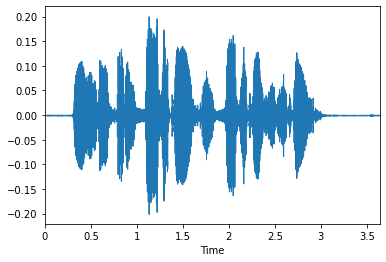

5% White Noise(Default)


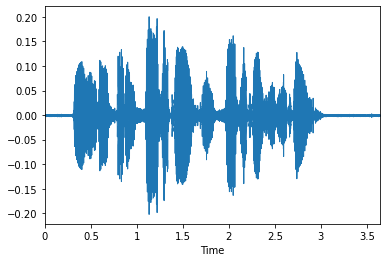

50% White Noise


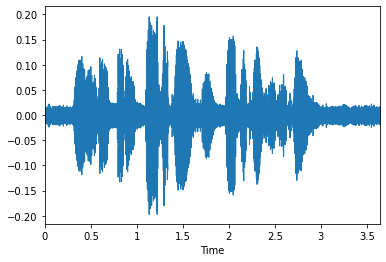

In [ ]:
noisy = AddNoise()
real_noisy = AddNoise(noise_level=0.5)
inp, out5 = show_transform(noisy, GenExample.audio_sc, show=None)
inp, out50 = show_transform(real_noisy, GenExample.audio_sc, show=None)
msgs = ["Original Audio", "5% White Noise(Default)", "50% White Noise"]
for i, aud in enumerate([inp, out5, out50]):
    print(msgs[i])
    aud.show(hear=False)

### Pink Noise Examples

Original Audio


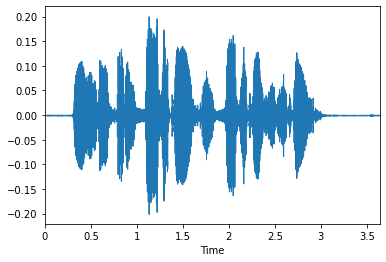

5% Pink Noise


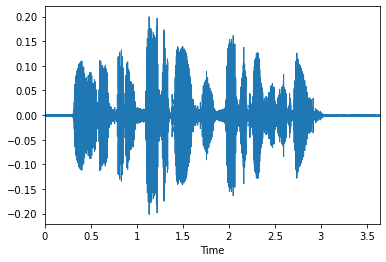

100% Pink Noise


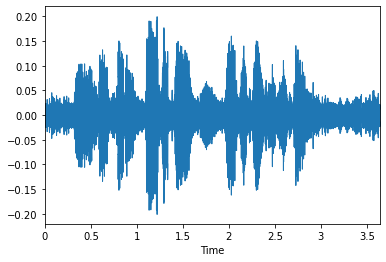

In [ ]:
noisy = AddNoise(color=NoiseColor.Pink)
real_noisy = AddNoise(noise_level=1, color=NoiseColor.Pink)
inp, out5 = show_transform(noisy, GenExample.audio_sc, show=None)
inp, out100 = show_transform(real_noisy, GenExample.audio_sc, show=None)
msgs = ["Original Audio", "5% Pink Noise", "100% Pink Noise"]
for i, aud in enumerate([inp, out5, out100]):
    print(msgs[i])
    aud.show(hear=False)

In [ ]:
# demonstrate blue-noise on multichannel data (change "show=False" to "show=True" to see)
noisy = AddNoise(noise_level=0.5, color=NoiseColor.Blue)
show_transform(noisy, GenExample.audio_mc, show=False)

(AudioTensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.8501e-04,
          -6.7139e-04, -2.4414e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.2207e-04,  1.8311e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.5259e-04,
           9.1553e-05,  3.0518e-05]]),
 AudioTensor([[ 0.0037, -0.0015, -0.0006,  ..., -0.0042,  0.0066, -0.0052],
         [ 0.0037, -0.0015, -0.0006,  ..., -0.0034,  0.0074, -0.0048],
         [ 0.0037, -0.0015, -0.0006,  ..., -0.0032,  0.0073, -0.0049]]))

#### Noise Timing Tests

In [ ]:
%%timeit -n10
noise = torch.from_numpy(cn.powerlaw_psd_gaussian(exponent=0, size=audio_orig.nsamples)).float()
scaled_noise = noise * audio_orig.data.abs().mean() * 0.05
out = AudioTensor(audio_orig.data + scaled_noise,audio_orig.sr)

3.15 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
#Same speed for white noise and brown noise using their algorithm
noise = torch.from_numpy(cn.powerlaw_psd_gaussian(exponent=2, size=audio_orig.nsamples)).float()
scaled_noise = noise * audio_orig.abs().mean() * 0.05
out = AudioTensor(audio_orig.data + scaled_noise,audio_orig.sr)

3.33 ms ± 88.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
noisy = AddNoise(color=NoiseColor.White)(audio_orig)

492 µs ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Adjust Volume

<div class = "alert alert-block alert-warning"><strong>Note:</strong><br> 
   This will increase/decrease the energy of the signal but so far it appears to do nothing besides change the absolute values as the audios sound the same, and the spectrograms appear the same. The gain is being correctly applied, but the ipython audio player seems to normalize the volume level (confirmed by outputting and downloading the clips and confirming a difference in noise level). The spectrogram appears the same because it too does a form of normalization when it sets `ref`. We will likely need to adjust the ref value to something constant like np.max or 0 to stop this normalization, as the noise_level is often relevant for deep learning and not something we want to strip out.<br></div>


In [ ]:
# export
@patch
def apply_gain(ai:AudioTensor, gain):
    ai.data *= gain
    return ai

In [ ]:
#export
class ChangeVolume(RandTransform):
    def __init__(self, p=0.5, lower=0.5, upper=1.5):
        self.lower, self.upper = lower, upper
        super().__init__(p=p)
        
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.gain = random.uniform(self.lower, self.upper)
        
    def encodes(self, ai:AudioTensor): return apply_gain(ai, self.gain)

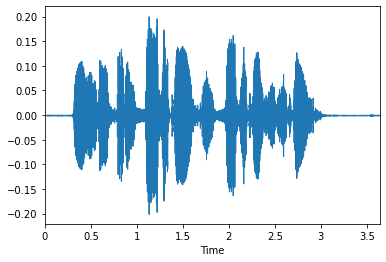

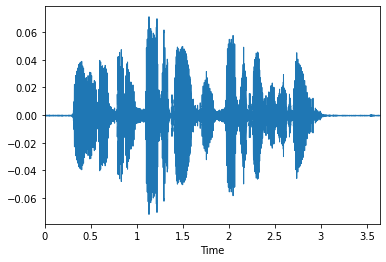

In [ ]:
#ipython player normalizes out volume difference, note different y-axis scale but same sound.
volume_adjuster = ChangeVolume(p=1, lower=0.01, upper=0.5)
inp, out = show_transform(volume_adjuster, GenExample.audio_sc)

#### Adjust Volume Timing Tests

In [ ]:
audio_orig = GenExample.audio_sc
audio_mc = GenExample.audio_mc

In [ ]:
%%timeit -n10
volume_adjuster(audio_orig, split_idx=0)

34.9 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
volume_adjuster(audio_mc, split_idx=0)

35.6 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Signal Cutout

In [ ]:
# export
@patch
def cutout(ai:AudioTensor, cut_pct):
    mask = torch.zeros(int(ai.nsamples*cut_pct))
    mask_start = random.randint(0,ai.nsamples-len(mask))
    ai.data[:,mask_start:mask_start+len(mask)] = mask
    return ai

# @patch
# def cutout(sg:AudioSpectrogram, cut_pct):

In [ ]:
#export
class SignalCutout(RandTransform):
    def __init__(self, p=0.5, max_cut_pct=0.15):
        self.max_cut_pct = max_cut_pct
        super().__init__(p=p)
        
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.cut_pct = random.uniform(0, self.max_cut_pct)
        
    def encodes(self, ai:AudioTensor): return cutout(ai, self.cut_pct)

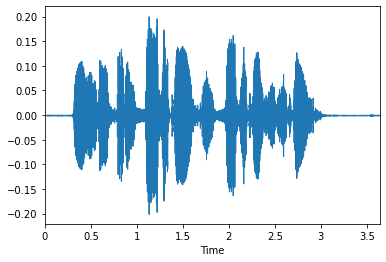

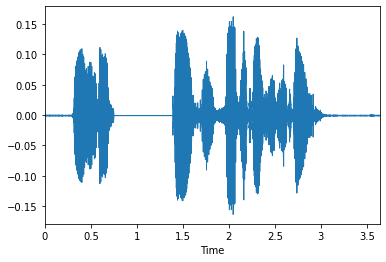

In [ ]:
cutter = SignalCutout(p=1, max_cut_pct=0.3)
inp, out = show_transform(cutter, GenExample.audio_sc)

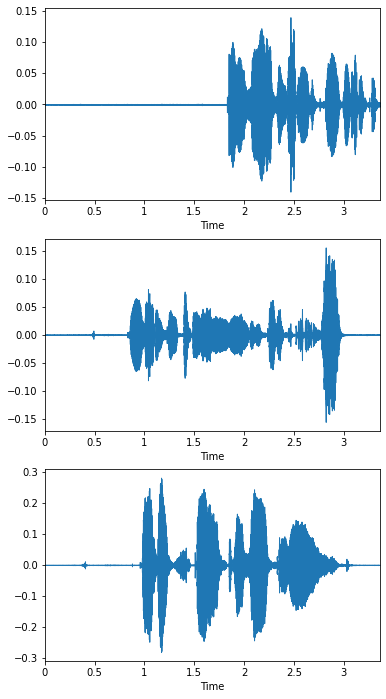

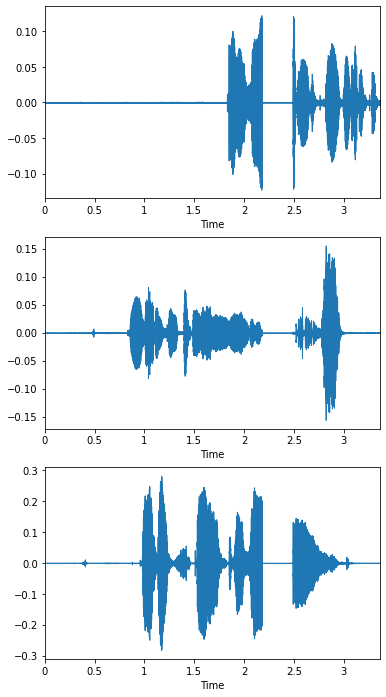

In [ ]:
# demonstrate SignalCutout on multichannel, confirm the cuts align, (change "show=None" to "show=True" to see)
cut_mc = SignalCutout(p=1, max_cut_pct=0.5)
inp, out = show_transform(cut_mc, GenExample.audio_mc, show=True)

#### Signal Cutout Timing Tests

In [ ]:
audio_orig = GenExample.audio_sc
audio_mc = GenExample.audio_mc

In [ ]:
%%timeit -n10
cutter(audio_orig, split_idx=0)

34.6 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
cutter(audio_mc, split_idx=0)

35 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Signal Loss 

In [ ]:
# export
@patch
def lose_signal(ai:AudioTensor, loss_pct):
    mask = (torch.rand_like(ai.data[0])>loss_pct).float()
    ai.data[...,:] *= mask
    return ai

In [ ]:
# export
class SignalLoss(RandTransform):
    def __init__(self, p=0.5, max_loss_pct = 0.15):
        self.max_loss_pct = max_loss_pct
        super().__init__(p=p)

    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.loss_pct = random.uniform(0, self.max_loss_pct)
        
    def encodes(self, ai:AudioTensor): return lose_signal(ai, self.loss_pct)

In [ ]:
dropper = SignalLoss(p=1, max_loss_pct=0.3)
inp, out = show_transform(dropper, GenExample.audio_sc, show=False, hear=True)
print(f"Percent Dropped: {100*dropper.loss_pct:.2f}")

Percent Dropped: 7.87


In [ ]:
# Updating to a RandTransform broke these tests

# verify SignalDrop is dropping both the correct number of samples, and dropping
# the same samples from each channel, over a wide range of cut_pcts
# nsamples = fake_multichannel.nsamples
# for cut_pct in np.linspace(0.05, 0.5, 45):
#     dropped_mc = SignalDrop(cut_pct)(fake_multichannel)
#     match1 = (dropped_mc.sig[0] == dropped_mc.sig[1]).sum()
#     match2 = (dropped_mc.sig[0] == dropped_mc.sig[2]).sum()
#     match3 = (dropped_mc.sig[1] == dropped_mc.sig[2]).sum()
#     test_close(match1, cut_pct*nsamples, eps=.02*nsamples)
#     test_close(match2, cut_pct*nsamples, eps=.02*nsamples)
#     test_close(match3, cut_pct*nsamples, eps=.02*nsamples)

#### Signal Drop Timing Tests

In [ ]:
audio_orig = GenExample.audio_sc
audio_mc = GenExample.audio_mc

In [ ]:
%%timeit -n10
dropper(audio_orig, split_idx=0)

35.1 µs ± 2.22 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
dropper(audio_mc, split_idx=0)

34.5 µs ± 4.28 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## DownmixMono

In [ ]:
#export
# downmixMono was removed from torchaudio, we now just take the mean across channels
# this works for both batches and individual items
class DownmixMono(Transform):
    def encodes(self, ai: AudioTensor)->AudioTensor:
        downmixed = ai.data.contiguous().mean(-2).unsqueeze(-2)
        return AudioTensor(downmixed, ai.sr)


In [ ]:
aud = GenExample.audio_mc()
DownmixMono()(aud)

AudioTensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.4414e-04,
         -1.5259e-04, -1.0173e-05]])

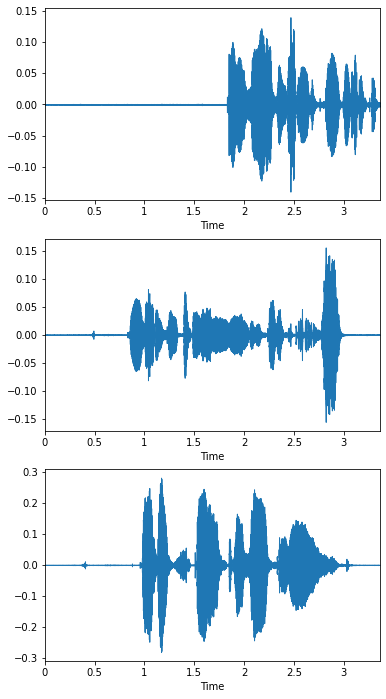

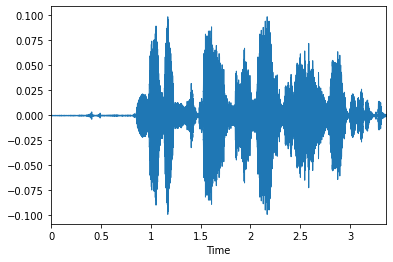

In [ ]:
downmixer = DownmixMono()
inp, out = show_transform(downmixer, GenExample.audio_mc, show=True)

In [ ]:
# test downmixing 1 channel has no effect
inp, out = show_transform(downmixer, GenExample.audio_sc, show=None)
test_eq(inp.data, out.data)

In [ ]:
# example showing a batch of 8 signals 
inp, out = show_transform(downmixer, GenExample.audio_mc_batch, show=None)
print(f"Before shape: {inp.shape}\nAfter shape: {out.shape}")

Before shape: torch.Size([8, 3, 53760])
After shape: torch.Size([8, 1, 53760])


#### DownmixMono Timing Tests

In [ ]:
audio_mc = GenExample.audio_mc()

In [ ]:
%%timeit -n10
downmixer(audio_mc)

88.9 µs ± 8.81 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()